# A Simple Classical Classifier

_This notebook explores the creation and use of a classical model in **PyTorch** to compare against **PennyLane**_.

**By:** Jacob Cybulski<br>
**Date:** October 2024<br>
**Aims:** The goal of this notebook is to develop a simple classical model, similar to a quantum model in PennyLane, and compare them.<br/>

## Libraries

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/demos',
 '/home/jacob/miniconda3/envs/pl/lib/python310.zip',
 '/home/jacob/miniconda3/envs/pl/lib/python3.10',
 '/home/jacob/miniconda3/envs/pl/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl/lib/python3.10/site-packages',
 '.']

In [2]:
### General libraries

import os
import pylab
import math
import time
import copy
import numpy as nnp
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
### Import utilities
from utilities import *

## Load previously prepared data set

Data sets to chose from (require: pip install ucimlrepo):
- <a href="https://archive.ics.uci.edu/dataset/10/automobile" target="_blank">Automobiles</a>:
  This is a database of automobile specs. The task is to either predict the car price or determine its insurance risk (symboling).
- <a href="https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks" target="_blank">Sonar</a>:
  The task is to discriminate between sonar signals bounced off a mine (metal cylinder) or a rock (roughly cylindrical).
  
_**Data prepared according to the following objectives:**_

- *Fetch and understand data*
- *Select numeric variables only*
- *Deal with missing values*
- *Prepare the label (change it to binary)*
- *Standardise predictors*
- *Reduce dimensionality using PCA*


### Files location

In [4]:
RSRC_STORE = 'rsrc'
RSRC_NAME = 'simple_auto'

### Data set in its original form

In [5]:
from ucimlrepo import fetch_ucirepo

auto = fetch_ucirepo(id=10)

# data (as pandas dataframes) 
X_vars = auto.data.features 
y_class = auto.data.targets 
  
# metadata 
print(auto.metadata['additional_info']['summary'],'\n') 
  
# variable information 
# print(auto.variables) 

This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars.  The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price.   Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale.  Actuarians call this process "symboling".  A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year.  This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.

Note: Several of the attributes in the database could be used as a "class" attribute. 



In [6]:
X_vars.head(5)

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,...,length,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses
0,13495.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
1,16500.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
2,16500.0,26,19,5000.0,154.0,9.0,3.47,2.68,mpfi,152,...,171.2,94.5,front,rwd,hatchback,2.0,std,gas,alfa-romero,NaN
3,13950.0,30,24,5500.0,102.0,10.0,3.40,3.19,mpfi,109,...,176.6,99.8,front,fwd,sedan,4.0,std,gas,audi,164.0
4,17450.0,22,18,5500.0,115.0,8.0,3.40,3.19,mpfi,136,...,176.6,99.4,front,4wd,sedan,4.0,std,gas,audi,164.0


### Load data from the store

In [7]:
x_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_x.pkl')
y_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_y.pkl')
X_pca = pd.read_pickle(x_file_path)
y = pd.read_pickle(y_file_path)
print(f'\nRead previously prepared data set:   "{RSRC_NAME}" in store "{RSRC_STORE}"\n')


Read previously prepared data set:   "simple_auto" in store "rsrc"



In [8]:
### Sample of saved X predictors
nnp.round(X_pca[7:12], 3)

,PC00,PC01,PC02,PC03,PC04,PC05,PC06,PC07
7,1.309,0.300,-0.380,-0.279,-0.583,-0.224,0.000,0.080
8,1.404,0.612,-0.500,-0.491,-0.684,-0.113,-0.094,0.275
9,-0.650,1.271,-0.318,-0.086,-0.307,-0.316,0.018,-0.097
10,-0.918,0.757,-0.158,0.132,-0.592,0.702,-0.097,0.224
11,0.592,-0.278,-0.712,-0.322,-0.267,0.821,-0.115,0.256


In [9]:
### Sample of saved y label
y[7:12]

,symboling
7,1
8,1
9,0
10,1
11,0


## Create a simple classical model

We will first identify what devices and gradient support we have, then prepare data for model training and testing, create a classical model, and finally train it and test it.

In [10]:
### Torch

from torch import nn
from torch.autograd import Variable
import torch

### Utilities

In [11]:
### Performance measurements

def square_loss(labels, predictions):
    sq_diffs = torch.tensor([(l - p)**2 for l, p in zip(labels, predictions)])
    return sq_diffs.mean().item()

def accuracy(labels, predictions, prec=1e-5):
    acc = sum(abs(l - p) < prec for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc.item()

### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Define device to compute on

In [12]:
### Find what devices are available

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Force CPU
torch_device = "cpu"
(torch_device)

'cpu'

### Configuration constants

In [13]:
### Data params
n_data = 4
x_angle_margin = 0
x_angle_min = 0+x_angle_margin
x_angle_max = 1-x_angle_margin

### Training params
epochs = 2000
prompt_fract = 0.05
acc_prec = 0.5
log_interv = 1
seed = 2024

### Prepare data for the classifier

In [14]:
### Check ranges
print(f'Min X={X_pca.to_numpy().min().round(3)}, Max X={X_pca.to_numpy().max().round(3)}, '+\
      f'Min y={y.to_numpy().min().round(3)}, Max y={y.to_numpy().max().round(3)}')

Min X=-2.276, Max X=3.081, Min y=0, Max y=1


In [15]:
### Standardise X values to the range 0..pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
angle_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
scaled = angle_scaler.fit_transform(X_pca) 
X = pd.DataFrame(scaled, columns=X_pca.columns)

# Recheck the X ranges
print(f'Min X={X.to_numpy().min().round(3)}, Max X={X.to_numpy().max().round(3)}')

Min X=0.0, Max X=1.0


In [16]:
### Create data partitions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,0:n_data], y.iloc[:,0:n_data], 
                                                    test_size=0.33, random_state=seed)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(137, 4), X_test=(68, 4), y_train=(137, 1), y_test=(68, 1)


In [17]:
### Change the data format to tensors
X_train_tens = torch.tensor(np.array(X_train), dtype=torch.double)
y_train_tens = torch.tensor(np.array(y_train), dtype=torch.double)
X_test_tens  = torch.tensor(np.array(X_test), dtype=torch.double)
y_test_tens  = torch.tensor(np.array(y_test), dtype=torch.double)

In [18]:
### Sample training predictors
print(X_train_tens[0:5])

tensor([[0.8883, 0.4610, 0.8176, 0.3153],
        [0.7041, 0.3459, 0.1770, 0.5171],
        [0.6178, 0.2638, 0.1689, 0.2953],
        [0.1620, 0.2671, 0.3704, 0.5715],
        [0.3020, 0.5317, 0.2455, 0.3817]], dtype=torch.float64)


In [19]:
### Sample training labels
y_train_tens[0:5]

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.]], dtype=torch.float64)

### Model training functions

In [20]:
### Classic classifier
class Classic_Auto(nn.Module):

    def __init__(self, in_shape, out_shape):
        super(Classic_Auto, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(in_shape, 32),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Linear(32, 8),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(8, out_shape)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
### Test if the model works as a function
test = Classic_Auto(in_shape=X_train_tens.shape[1], out_shape=y_train_tens.shape[1]).double().to(torch_device)
test(X_train_tens[0:5])

tensor([[-0.1687],
        [-0.2319],
        [-0.0179],
        [-0.2075],
        [-0.2349]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [22]:
### Trains the classical AE model
def train_classical(model, X, y, cost_fun, acc_fun, optimizer, epochs, log_interv=100, prompt_fract=0.1, acc_prec=0.3):
    history = []
    acc_hist = []
    min_epoch = 0
    min_cost = 1000
    min_acc = 1000
    opt_params = {}
    hist_params = []
    running_loss = 0
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(X)
        cost = cost_fun(output, y)
        acc = acc_fun(output, y, prec=acc_prec)
        cost.backward()
        optimizer.step()

        curr_loss = cost.item()
        curr_acc = acc
        if curr_loss < min_cost: 
            min_cost = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if curr_acc < min_acc:
            min_acc = curr_acc

        if epoch % log_interv == 0:
            history.append(curr_loss)
            acc_hist.append(curr_acc)
            hist_params.append(copy.deepcopy(model.state_dict()))

        if epoch % int(prompt_fract*epochs) == 0:
            print(f'epoch {epoch} \t Loss: {curr_loss:.4g} \t Acc: {curr_acc:.4g}')
            
        running_loss += curr_loss

    return history, acc_hist, opt_params, hist_params, (min_epoch, min_cost)


### Model creation and training run

In [23]:
### Set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
c_auto = Classic_Auto(in_shape=X_train_tens.shape[1], out_shape=y_train_tens.shape[1]).double().to(torch_device)

### Loss and optimiser

cost_fun = nn.MSELoss()
# cost_fun = nn.L1Loss()

# opt = optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
opt = torch.optim.Adam(c_auto.parameters())

### Show 
c_auto.eval()

Classic_Auto(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=32, out_features=8, bias=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [24]:
### Train the model
# epochs = 10000
# log_interv = 10
# prompt_fract = 0

start = time.time()

history, acc_history, opt_params, hist_params, opt_point = \
    train_classical(c_auto, X_train_tens, y_train_tens, 
                    cost_fun, accuracy, opt, epochs, log_interv=log_interv, prompt_fract=prompt_fract, acc_prec=acc_prec)

elapsed = time.time() - start

# Print run statistics
print(f'\n'+
      f'{torch_device} Fit ('+
      f'{y_train_tens.shape[0]} samples, '+
      f'{X_train_tens.shape[1]} features, '+
      f'{count_params(c_auto)} params, '+
      f'{epochs} epochs): '+
      f'{round(opt_point[1], 5)} min cost @ iter# {opt_point[0]}, '+
      f'{elapsed:0.2f} sec'+
      f'\n'
     )

epoch 0 	 Loss: 0.9131 	 Acc: 0.3942
epoch 100 	 Loss: 0.2368 	 Acc: 0.7153
epoch 200 	 Loss: 0.1859 	 Acc: 0.7153
epoch 300 	 Loss: 0.1824 	 Acc: 0.7591
epoch 400 	 Loss: 0.1654 	 Acc: 0.7591
epoch 500 	 Loss: 0.1635 	 Acc: 0.7883
epoch 600 	 Loss: 0.1475 	 Acc: 0.8029
epoch 700 	 Loss: 0.1413 	 Acc: 0.8248
epoch 800 	 Loss: 0.1606 	 Acc: 0.781
epoch 900 	 Loss: 0.1527 	 Acc: 0.7664
epoch 1000 	 Loss: 0.1474 	 Acc: 0.7883
epoch 1100 	 Loss: 0.1315 	 Acc: 0.8248
epoch 1200 	 Loss: 0.1298 	 Acc: 0.8321
epoch 1300 	 Loss: 0.1166 	 Acc: 0.8394
epoch 1400 	 Loss: 0.1246 	 Acc: 0.8686
epoch 1500 	 Loss: 0.1328 	 Acc: 0.8394
epoch 1600 	 Loss: 0.1208 	 Acc: 0.854
epoch 1700 	 Loss: 0.1191 	 Acc: 0.8394
epoch 1800 	 Loss: 0.1124 	 Acc: 0.8394
epoch 1900 	 Loss: 0.1086 	 Acc: 0.8686

cpu Fit (137 samples, 4 features, 4689 params, 2000 epochs): 0.09347 min cost @ iter# 1970, 8.91 sec



In [25]:
### Training loss
c_auto.load_state_dict(opt_params)
pred = c_auto(X_train_tens)
print(f'Training acc={nnp.round(accuracy(pred, y_train_tens, prec=0.3), 4)},'+\
      f'loss={nnp.round(square_loss(pred, y_train_tens), 4)}')

Training acc=0.6496,loss=0.1232


In [26]:
### Testing accuracy at the point of the lowest loss
c_auto.load_state_dict(opt_params)
pred = c_auto(X_test_tens)
print(f'Testing acc={nnp.round(accuracy(pred, y_test_tens, prec=0.3), 4)},'+\
      f'loss={nnp.round(square_loss(pred, y_test_tens), 4)}')

Testing acc=0.7647,loss=0.1115


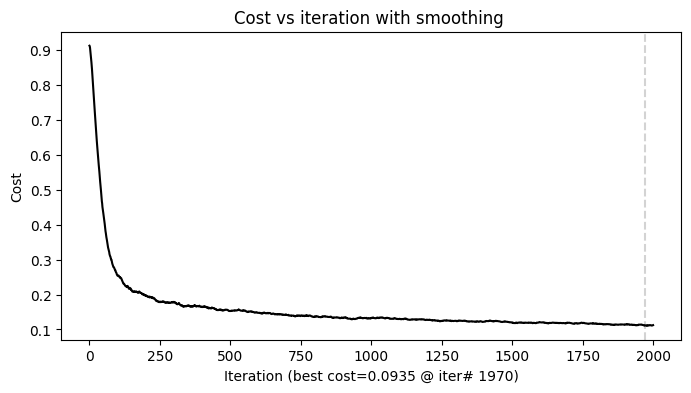

In [27]:
### Plot training cost
meas_plot(history, meas='cost', task='min',
                  rcParams=(8, 4), log_interv=log_interv,
                  backplot=False, back_color='linen', smooth_weight=0.95)

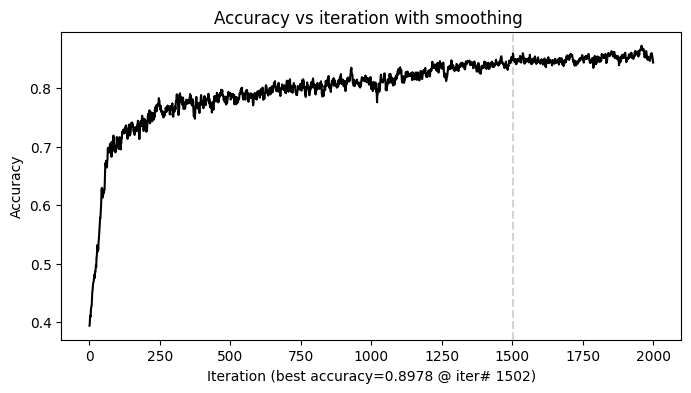

In [28]:
### Plot training accuracy
meas_plot(acc_history, meas='accuracy', task='max',
                  rcParams=(8, 4), log_interv=log_interv, 
                  backplot=False, back_color='linen', smooth_weight=0.8)

## What's next?
*At this point you can improve this notebook by performing the following tasks:*

- Save the history of loss and accuracy into a resource folder
- Save all model parameters kept during the model training into a resource folder
- Calculate, plot and archive MSE and accuracy scores for test data partition
- Play with the smoothing factor in all plots to gain insight into volatility of your scores
- Analyse all accumulated data and report your observations, reflect on your learning

*As an extension:*

- Prepare an Automobile data set, a model and its scores, to predict car price (exclude symboling which is a variable dependent on price)
- Repeat the entire process for the "sonar" data set (link included above)
- Enjoy learning predictive analytics using classical and quantum ML models

## System in use

In [29]:
!pip list | grep -e PennyLane -e torch

PennyLane                     0.38.0
PennyLane_Lightning           0.38.0
PennyLane_Lightning_GPU       0.38.0
torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
